# **Classification of Energy Consumption Levels in a Wastewater Treatment Plant**$^1$

$^1$ To be defined

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots, cm
import statsmodels.api as sm
from scipy.stats import boxcox

from ISLP import confusion_table

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression as LR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from ISLP.svm import plot as plot_svm
from sklearn.metrics import RocCurveDisplay

from sklearn.metrics import accuracy_score, classification_report
import sklearn.model_selection as skm

In [5]:
import math

In [6]:
df = pd.read_csv('data-melbourne.csv')

### **Pre-processing**

In [7]:
df = df.drop(['VG', 'TM', 'Tm', 'VM'], axis=1)
df = df.drop(['year', 'month', 'day','SLP','PP', 'VV'], axis=1)

In [8]:
df['total_grid'] = (df['total_grid']/1000)

#### **Removing Outliers**

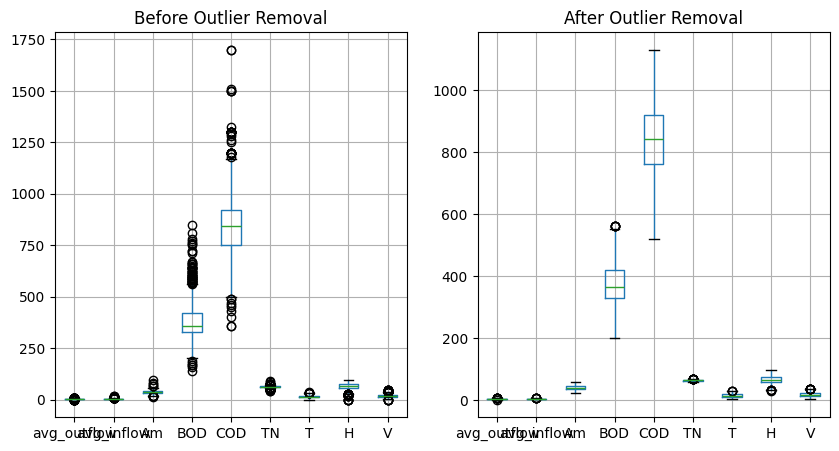

In [9]:
# Function to remove outliers using the IQR method
def remove_outliers_iqr(df):
    for col in df.select_dtypes(include=[np.number]).columns:  # Apply only to numerical columns
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out values outside the bounds
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

# Apply function to remove outliers
df_cleaned = remove_outliers_iqr(df)

df_pred = df.drop(['total_grid'],axis=1)
df_cleaned_pred = df_cleaned.drop(['total_grid'],axis=1)

# Boxplot to visualize before and after
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
df_pred.boxplot()
plt.title("Before Outlier Removal")

plt.subplot(1, 2, 2)
df_cleaned_pred.boxplot()
plt.title("After Outlier Removal")

plt.show()


#### **Solving Skewness**

In [10]:
avg_inflow_bcx, lambda_avg_inflow = boxcox(df_cleaned['avg_inflow'])
bod_bcx, lambda_bod = boxcox(df_cleaned['BOD'])
cod_bcx, lambda_cod = boxcox(df_cleaned['COD'])

In [11]:
df_cleaned['avg_inflow'] = avg_inflow_bcx
df_cleaned['BOD'] = bod_bcx
df_cleaned['COD'] = cod_bcx

#### **Centering and scaling predictors**

In [12]:
df_normalised = df_cleaned.copy()
# df_normalised = df.copy()

columns_to_plot = ['avg_outflow','avg_inflow','Am','BOD','COD','TN','T','H','V']

means = df[columns_to_plot].mean()
stds = df[columns_to_plot].std()

df_normalised[columns_to_plot] = (df[columns_to_plot] - means) / stds

In [13]:
np.min(df_normalised['total_grid'])

163.031

### **Classes Definition**

In [14]:
bins = [0, 237, 312, float('inf')]    # ranges for classification
labels = ['level 1', 'level 2', 'level 3']  # levels' labels

df_normalised['consumption_level'] = pd.cut(df_normalised['total_grid'], bins=bins, labels=labels, right=False)

In [15]:
level1_df = df_normalised[df_normalised['consumption_level'] == 'level 1']
level2_df = df_normalised[df_normalised['consumption_level'] == 'level 2']
level3_df = df_normalised[df_normalised['consumption_level'] == 'level 3']

In [16]:
level1_df.shape

(185, 11)

In [17]:
level1_df.head()

,avg_outflow,avg_inflow,total_grid,Am,BOD,COD,TN,T,H,V,consumption_level
0,-0.805359,-1.331870,175.856,-1.574715,-0.198401,-0.797436,-0.661643,0.789723,-0.520057,1.039293,level 1
1,-0.809428,-1.073462,181.624,-1.832394,-0.140259,-0.728668,-0.760214,0.382202,-0.038434,-0.712176,level 1
2,-0.815939,-0.890076,202.016,0.357877,0.417906,-0.068496,0.498805,0.326631,-1.139286,1.739880,level 1
3,-0.815939,-0.800466,207.547,-0.415160,0.557448,0.027779,0.072597,-0.080890,-1.001679,1.053304,level 1
4,-0.824891,-0.494822,202.824,0.873235,1.464467,1.169328,0.797877,-0.303175,0.099172,0.156552,level 1


### **Train and Test Data**

In [18]:
X = df_normalised.copy()
X = X.drop(['total_grid', 'consumption_level'], axis=1)

y = df_normalised['consumption_level']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## **Linear Classification Model**

### **Logistic Regression**

Sofmax: Select the class for which 

$$
    Pr(Y = k | X = x) = \cfrac{e^{\beta_{k0} + \beta_{k1} x_1 + \dots + \beta_{kp}x_p}}{\displaystyle \sum_{l=1}^K e^{\beta_{l0} + \beta_{l1}x_1 + \dots + \beta_{lp}x_p}}
$$

is largest

#### Scratch

In [21]:
class LogisticRegression:
    def __init__(self, X_train, X_test, y_train, y_test, max_iter):
        self.X_train = X_train  # train output
        self.X_test = X_test    # test output
        self.y_train = y_train  # train output
        self.y_test = y_test    # test output

        # vector of labels
        self.labels = np.array(np.unique(np.concatenate((self.y_train, self.y_test))))

        self.max_iter = max_iter    # maximum number of iterations

        self.obtainCoefficients()   # calculate the \Beta coefficients

    def obtainCoefficients(self):
        # model definition and fit
        model = LR(multi_class='multinomial', solver='lbfgs', max_iter=self.max_iter)
        model.fit(self.X_train, self.y_train)
        
        # coefficients obtained
        betas = model.coef_             # \Betas
        intercept = model.intercept_    # intercept

        # matrix of coeeficients
        self.coefficients = np.hstack((intercept.reshape(3,1), betas))

        return self.coefficients

    def predict(self):
        # matrix of probabilities for each class
        prob = np.zeros((X_test.shape[0], self.coefficients.shape[0]))

        # calculating the probabilities of a observation belonging to the class k
        for i in range(self.labels.shape[0]):
            for j in  range(self.X_test.shape[0]):
                prob_num = (math.exp(self.coefficients[i,0] + self.coefficients[i,1:] @ self.X_test.iloc[j]))
                prob_den = 0
                
                for k in range(self.labels.shape[0]):
                    prob_den = prob_den + (math.exp(self.coefficients[k,0] + self.coefficients[k,1:] @ self.X_test.iloc[j]))
                
                prob[j,i] = prob_num/prob_den
        
        # select the class with higher probability
        y_pred_idx = np.argmax(prob, axis=1)
        
        self.y_pred = np.array(self.labels)[y_pred_idx]

        return self.y_pred


In [22]:
lr_model = LogisticRegression(X_train, X_test, y_train, y_test, 500)
y_pred = lr_model.predict()

c:\Users\room2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [23]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6175298804780877
Classification Report:
               precision    recall  f1-score   support

     level 1       1.00      0.02      0.04        49
     level 2       0.62      0.99      0.76       153
     level 3       0.67      0.04      0.08        49

    accuracy                           0.62       251
   macro avg       0.76      0.35      0.29       251
weighted avg       0.70      0.62      0.49       251



In [24]:
confusion_table(y_pred, y_test)

Truth,level 1,level 2,level 3
Predicted,,,
level 1,1,0,0
level 2,48,152,47
level 3,0,1,2


#### Library

In [25]:
model = LR(multi_class='multinomial', solver='lbfgs', max_iter=500)
model.fit(X_train, y_train)

c:\Users\room2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=500, multi_class='multinomial')

In [26]:
y_pred = model.predict(X_test)

In [27]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6175298804780877
Classification Report:
               precision    recall  f1-score   support

     level 1       1.00      0.02      0.04        49
     level 2       0.62      0.99      0.76       153
     level 3       0.67      0.04      0.08        49

    accuracy                           0.62       251
   macro avg       0.76      0.35      0.29       251
weighted avg       0.70      0.62      0.49       251



In [28]:
confusion_table(y_pred, y_test)

Truth,level 1,level 2,level 3
Predicted,,,
level 1,1,0,0
level 2,48,152,47
level 3,0,1,2


### **Linear Discriminant Analysis**

#### Scratch

In [29]:
class LinearDiscriminant():
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test  = X_test
        self.y_train = y_train
        self.y_test  = y_test

        self.getLabels()
        self.getMeans()
        self.getPriors()
        self.covarianceMatrix()

    def getLabels(self):
        self.labels = np.array(np.unique(np.concatenate((self.y_train, self.y_test))))
        return self.labels

    def getMeans(self):
        self.means = np.zeros((self.labels.shape[0], self.X_train.shape[1]))    # matrix of means

        for k in range(self.labels.shape[0]):
            df_label     = self.X_train[self.y_train == self.labels[k]] # dataframe of class i

            for j in range(self.X_train.shape[1]):
                self.means[k,j] = np.mean(df_label.iloc[:,j])   # calculating the means

    def getPriors(self):
        self.pi  = np.zeros(self.labels.shape)                          # vector of prioris

        for k in range(self.labels.shape[0]):
            df_label   = self.X_train[self.y_train == self.labels[k]]   # dataframe of class i
            self.pi[k] = df_label.shape[0]/self.X_train.shape[0]        # calculating priori of i

        return self.pi

    def covarianceMatrix(self):
        N = self.X_train.shape[0]                                                   # number of observations
        mean            = np.mean(self.X_train, axis=0)                             # means
        self.cov_matrix = np.dot((self.X_train - mean).T, X_train - mean)/(N-1)     # covariance matrix

    def predict(self):
        S_inv   = np.linalg.inv(self.cov_matrix)                            # covariance matrix (inverse)
        D       = np.zeros((self.X_test.shape[0], self.labels.shape[0]))    # discriminants matrix

        for k in range(self.labels.shape[0]):
            mu_k   = self.means[k]      # vector of means
            mu_k_T = (self.means[k]).T  # vector of means (transpose)
            pi_k   = self.pi[k]         # priori of class k

            for j in  range(self.X_test.shape[0]):
                x_T = (self.X_test.iloc[j]).T                                           # observation x
                d_k_x = x_T @ S_inv @ mu_k - 0.5*(mu_k_T @ S_inv @ mu_k) + np.log(pi_k) # calculate discriminant of observation x for class k
                D[j,k] = d_k_x                                                          # storing discriminant
        
        y_pred_idx = np.argmax(D, axis=1)               # determine the index of the largest discriminant
        self.y_pred = np.array(self.labels)[y_pred_idx] # determine the predicted labels

        return self.y_pred

$$
    \delta_k(x) = x^T \Sigma^{-1} \mu_k - \cfrac{1}{2}\mu_k^T \Sigma^{-1} \mu_k + \log \pi_k
$$

In [30]:
lda_model = LinearDiscriminant(X_train, X_test, y_train, y_test)
lda_pred = lda_model.predict()

In [31]:
print("Classification Report:\n", classification_report(y_test, lda_pred))

Classification Report:
               precision    recall  f1-score   support

     level 1       1.00      0.02      0.04        49
     level 2       0.61      1.00      0.76       153
     level 3       1.00      0.02      0.04        49

    accuracy                           0.62       251
   macro avg       0.87      0.35      0.28       251
weighted avg       0.76      0.62      0.48       251



In [32]:
confusion_table(lda_pred, y_test)

Truth,level 1,level 2,level 3
Predicted,,,
level 1,1,0,0
level 2,48,153,48
level 3,0,0,1


#### Library

In [33]:
lda = LDA(store_covariance=True)
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [34]:
lda_model.cov_matrix

array([[ 5.01497274e-01,  2.28855346e-01,  6.37479278e-02,
        -9.14481084e-02,  4.32594592e-02,  1.72000867e-02,
        -1.61015121e-02,  1.84194065e-02,  1.39183447e-02],
       [ 2.28855346e-01,  2.36946664e-01,  2.95278081e-02,
        -7.44464489e-02,  3.95282974e-02,  1.53931795e-02,
         3.48263782e-03, -2.77343266e-04,  1.10481464e-02],
       [ 6.37479278e-02,  2.95278081e-02,  7.74967747e-01,
         2.90363111e-02,  1.23107331e-01,  1.16119994e-01,
         9.00129904e-02, -6.02389958e-02, -2.23038231e-02],
       [-9.14481084e-02, -7.44464489e-02,  2.90363111e-02,
         5.45540358e-01,  1.89737752e-01,  1.43583321e-01,
         6.65685175e-02, -5.36132472e-02, -2.03244518e-02],
       [ 4.32594592e-02,  3.95282974e-02,  1.23107331e-01,
         1.89737752e-01,  5.45144104e-01,  2.60292544e-01,
         1.18685560e-02, -7.08264593e-02, -1.17668495e-03],
       [ 1.72000867e-02,  1.53931795e-02,  1.16119994e-01,
         1.43583321e-01,  2.60292544e-01,  2.662355

In [35]:
lda.covariance_

array([[ 0.49199888,  0.2225763 ,  0.07091898, -0.08462844,  0.03647941,
         0.02160885,  0.00694759,  0.00581501,  0.0121251 ],
       [ 0.2225763 ,  0.23243479,  0.03450702, -0.06967274,  0.03517731,
         0.01819757,  0.01849285, -0.00827049,  0.01007989],
       [ 0.07091898,  0.03450702,  0.7678981 ,  0.02339304,  0.12828978,
         0.11244748,  0.07137404, -0.05019015, -0.0209913 ],
       [-0.08462844, -0.06967274,  0.02339304,  0.53960219,  0.19435291,
         0.14019175,  0.04953739, -0.04447986, -0.01918023],
       [ 0.03647941,  0.03517731,  0.12828978,  0.19435291,  0.53889969,
         0.2635991 ,  0.03029068, -0.08114182, -0.00292445],
       [ 0.02160885,  0.01819757,  0.11244748,  0.14019175,  0.2635991 ,
         0.26346374,  0.15244807, -0.12333462,  0.02589939],
       [ 0.00694759,  0.01849285,  0.07137404,  0.04953739,  0.03029068,
         0.15244807,  0.76001033, -0.41579915,  0.05444326],
       [ 0.00581501, -0.00827049, -0.05019015, -0.04447986, -0

In [36]:
lda.means_

array([[-0.24959434, -0.31195178,  0.10967161, -0.02445328, -0.18890253,
         0.10192662,  0.33384973, -0.13405044, -0.16334819],
       [-0.13196481, -0.2617853 ,  0.0338882 , -0.08642827, -0.05193798,
         0.00997181, -0.0800484 ,  0.13178672, -0.09274755],
       [ 0.0470977 , -0.11953333, -0.12819909, -0.24178583,  0.05032266,
        -0.0562458 , -0.47000829,  0.31630443, -0.09047291]])

In [37]:
lda.classes_

array(['level 1', 'level 2', 'level 3'], dtype='<U7')

In [38]:
lda.priors_

array([0.18085106, 0.6143617 , 0.20478723])

In [39]:
lda_pred = lda.predict(X_test)

In [40]:
confusion_table(lda_pred, y_test)

Truth,level 1,level 2,level 3
Predicted,,,
level 1,1,1,0
level 2,48,152,47
level 3,0,0,2


In [41]:
print("Classification Report:\n", classification_report(y_test, lda_pred))

Classification Report:
               precision    recall  f1-score   support

     level 1       0.50      0.02      0.04        49
     level 2       0.62      0.99      0.76       153
     level 3       1.00      0.04      0.08        49

    accuracy                           0.62       251
   macro avg       0.71      0.35      0.29       251
weighted avg       0.67      0.62      0.49       251



## **Nonlinear Classification Model**

### **Quadratic Discriminant Analysis**

$$
    \delta_k(x) = -\cfrac{1}{2} x^T \Sigma_k^{-1} x + x^T \Sigma_K^{-1} \mu_k - \cfrac{1}{2} \mu_k^T \Sigma_k^{-1} \mu_k - \cfrac{1}{2} \log \vert \Sigma_k \vert + \log \pi_k
$$

#### Scratch

In [42]:
class QuadraticDiscriminant():
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train  # train predictors
        self.X_test  = X_test   # test predictors
        self.y_train = y_train  # train output
        self.y_test  = y_test   # test output

        self.getLabels()        # determine the labels present in the dataset
        self.getMeans()         # calculate the mean for each class k
        self.getPriors()        # calculate prior for each class k
        self.covariances()      # calculate covariance matrix for each class k

    # determine the labels present in the dataset
    def getLabels(self):
        self.labels = np.array(np.unique(np.concatenate((self.y_train, self.y_test))))
        return self.labels

    # calculate the mean for each class k
    def getMeans(self):
        self.means = np.zeros((self.labels.shape[0], self.X_train.shape[1]))    # matrix of means

        for k in range(self.labels.shape[0]):
            df_label     = self.X_train[self.y_train == self.labels[k]]         # dataframe of class i

            for j in range(self.X_train.shape[1]):
                self.means[k,j] = np.mean(df_label.iloc[:,j])                   # calculating the means

    # calculate prior for each class k
    def getPriors(self):
        self.pi  = np.zeros(self.labels.shape)                          # vector of prioris

        for k in range(self.labels.shape[0]):
            df_label     = self.X_train[self.y_train == self.labels[k]] # dataframe of class i
            self.pi[k] = df_label.shape[0]/self.X_train.shape[0]        # calculating priori of i

        return self.pi
    
    # calculate covariance matrix for each class k
    def covariances(self):
        p = self.X_train.shape[1]   # number of predictors
        K = self.labels.shape[0]    # number of classes
        self.S = np.zeros((K,p,p))  # covariance matrix of class k

        for k in range(K):
            class_k = self.X_train[self.y_train == self.labels[k]]  # class k dataset
            mean_k = self.means[k]                                  # vector of means for class k
            n = class_k.shape[0]                                    # number of observations in class k

            self.S[k,:,:] = np.dot((class_k - mean_k).T, class_k - mean_k)/(n-1) # calculate covariance matrix for class k
    
    # predict the outputs for the test set
    def predict(self):
        K = self.labels.shape[0]    # number of classes
        n = self.X_test.shape[0]    # number of observations
        D = np.zeros((n,K))         # matrix of the discriminants of each class for each observation

        for k in range(K):
            S_k     = self.S[k,:,:]         # covariance matrix for class k
            S_k_inv = np.linalg.inv(S_k)    # covariance matrix for class k (inverse)
            mu_k    = self.means[k]         # vector of means of class k
            mu_k_T  = mu_k.T                # vector of means of class k (transpose)
            pi_k    = self.pi[k]            # prior of class k

            for i in range(n):
                x     = self.X_test.iloc[i] # observation i
                x_T   = x.T                 # observation i (transpose)

                # calculate discriminant of observation i for class k
                d_k_x = -0.5*(x_T @ S_k_inv @ x) + x_T @ S_k_inv @ mu_k - 0.5*(mu_k_T @ S_k_inv @ mu_k) - 0.5*(np.log(np.linalg.det(S_k))) + np.log(pi_k)

                D[i,k] = d_k_x  # store discriminant

        y_pred_idx = np.argmax(D, axis=1)               # determine the index of the largest discriminant
        self.y_pred = np.array(self.labels)[y_pred_idx] # determine the predicted labels

        return self.y_pred

In [43]:
qda_model = QuadraticDiscriminant(X_train, X_test, y_train, y_test)
qda_pred = qda_model.predict()

In [44]:
confusion_table(qda_pred, y_test)

Truth,level 1,level 2,level 3
Predicted,,,
level 1,2,7,0
level 2,45,137,43
level 3,2,9,6


In [45]:
print("Classification Report:\n", classification_report(y_test, qda_pred))

Classification Report:
               precision    recall  f1-score   support

     level 1       0.22      0.04      0.07        49
     level 2       0.61      0.90      0.72       153
     level 3       0.35      0.12      0.18        49

    accuracy                           0.58       251
   macro avg       0.39      0.35      0.33       251
weighted avg       0.48      0.58      0.49       251



#### Library

In [46]:
qda = QDA(store_covariance=True)
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [47]:
qda.means_, qda.priors_

(array([[-0.24959434, -0.31195178,  0.10967161, -0.02445328, -0.18890253,
          0.10192662,  0.33384973, -0.13405044, -0.16334819],
        [-0.13196481, -0.2617853 ,  0.0338882 , -0.08642827, -0.05193798,
          0.00997181, -0.0800484 ,  0.13178672, -0.09274755],
        [ 0.0470977 , -0.11953333, -0.12819909, -0.24178583,  0.05032266,
         -0.0562458 , -0.47000829,  0.31630443, -0.09047291]]),
 array([0.18085106, 0.6143617 , 0.20478723]))

In [48]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, y_test)

Truth,level 1,level 2,level 3
Predicted,,,
level 1,2,7,0
level 2,45,137,43
level 3,2,9,6


In [49]:
print("Classification Report:\n", classification_report(y_test, qda_pred))

Classification Report:
               precision    recall  f1-score   support

     level 1       0.22      0.04      0.07        49
     level 2       0.61      0.90      0.72       153
     level 3       0.35      0.12      0.18        49

    accuracy                           0.58       251
   macro avg       0.39      0.35      0.33       251
weighted avg       0.48      0.58      0.49       251



### **K-Nearest Neighbors**

#### Scratch

Euclidean distance:

$$
    d(p,q) = \sqrt{\sum_{i=1}^{n}(q_i - p_i)^2}
$$

* $p$, $q$     = two points in Euclidian n-space
* $q_i$, $p_i$ = Euclidian vectors, starting from the origin of the space (initial point)
* $n$          = n-space

In [50]:
class KNeighbors():
    def __init__(self, k, X_train, X_test, y_train, y_test):
        self.K = k              # number of neighbors

        self.X_train = X_train  # train predictors
        self.X_test  = X_test   # test predictors
        self.y_train = y_train  # train output
        self.y_test  = y_test   # test output

        self.n_train = self.X_train.shape[0]    # number of train observations
        self.n_test  = self.X_test.shape[0]     # number of test observations

        self.getLabels()        # determine the labels present in the dataset

        self.n_classes = self.labels.shape[0]   # number of classes

    # determine the labels present in the dataset
    def getLabels(self):
        self.labels = np.array(np.unique(np.concatenate((self.y_train, self.y_test))))
        return self.labels
    
    def calculateDistance(self, x_test, x_train):
        # euclidean distance
        sqr_diff = (x_test - x_train)**2    # squared difference between the vector
        sum_sqr_diff = np.sum(sqr_diff)     # sum of the squared difference
        d = sum_sqr_diff**(1/2)             # square root of the sum
        
        d = np.sum(np.abs(x_test-x_train))  # manhattan distance
        return d
    
    def distances(self):
        D = np.zeros((self.n_test, self.n_train)) # matrix of distances

        # calculate matrix of distances
        for i in range(self.n_test):
            x_test = self.X_test.iloc[i]          # test observation
            
            for j in range(self.n_train):
                x_train = self.X_train.iloc[j]                      # train observation
                D[i,j] = self.calculateDistance(x_test, x_train)    # calculate distance between test sample i and train sample j

        return D
    
    def countClasses(self, nearest_classes):
        counted_classes = np.zeros((self.n_test, self.n_classes)) # matrix of class occurence in neighbors

        for k in range(self.n_classes):
            counted_classes[:,k] = np.sum(nearest_classes == self.labels[k], axis=1)

        return counted_classes

    def predict(self):
        D = self.distances()

        nearest_indexes = np.argsort(D, axis=1)[:, -self.K:][:, ::-1]   # matrix of nearest neighbors indexes
        nearest_classes = np.empty((self.n_test, self.K), dtype=object) # matrix of nearest neighbors classes
        
        # getting the classes corresponding to the indices
        for i in range(self.n_test):
            for k in range(self.K):
                nearest_classes[i,k] = self.y_train.iloc[nearest_indexes[i,k]]

        # counting number of classes for each y_test observation
        counted_classes = self.countClasses(nearest_classes)
        
        y_pred_idx  = np.argmax(counted_classes, axis=1)    # determine the index of the largest occurence
        self.y_pred = np.array(self.labels)[y_pred_idx]     # determine the predicted labels

        return self.y_pred


In [51]:
class confusion():
    def __init__(self, y_test, y_pred):
        self.y_test = y_test                # test output set
        self.y_pred = y_pred                # predicted output set

        self.n_tests = self.y_test.shape[0] # number of test observations

        self.getClasses()                   # obtain vector of classes
        self.classes.sort()                 # sort the vector of classes

        self.n_classes = self.classes.shape[0]  # number of classes

    # obtain vector of classes
    def getClasses(self):
        self.classes = np.array(np.unique(np.concatenate((self.y_pred, self.y_test))))
        return self.classes
    
    # obtain confusion matrix
    def getConfusion(self):
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes)) # confusion matrix

        for i in range(self.n_tests):
            k_true = np.where(self.classes == y_test.iloc[i])       # index of true class
            k_pred = np.where(self.classes == y_pred[i])            # index of predicted class

            self.confusion_matrix[k_true, k_pred] += 1              # iterate in the correct row and column

        self.confusion_matrix = self.confusion_matrix.astype(int)   # transform matrix type for int
        
        df_confusion = pd.DataFrame(self.confusion_matrix)          # transform confusion matrix in a dataframe
        df_confusion.columns = self.classes                         # rename columns name
        df_confusion.index = self.classes                           # rename rows name

        return df_confusion
    
    # calculate model metrics
    def getMetrics(self):
        true_total = np.trace(self.confusion_matrix)        # total number of correct predictions
        total      = np.sum(self.confusion_matrix)          # number of predictions (equal to number of test elements)  
        self.accuracy  = true_total/total                   # accuracy
        
        self.precision = np.zeros(self.n_classes)           # precision vector
        self.recall    = np.zeros(self.n_classes)           # recall vector
        
        for k in range(self.n_classes):
            true_    = self.confusion_matrix[k,k]           # number of correct predicitons for class k
            pred_k   = np.sum(self.confusion_matrix[:,k])   # total number of predictions for class k
            actual_k = np.sum(self.confusion_matrix[k,:])   # number of elements in class k

            self.precision[k] = true_/(true_ + pred_k)      # precision for class k
            self.recall[k] = true_/(true_ + actual_k)       # recall for class k


In [52]:
conf = confusion(y_test, y_pred)
confusion_matrix = conf.getConfusion()
conf.getMetrics()

In [53]:
conf.accuracy
conf.precision

array([0.5       , 0.38095238, 0.4       ])

In [54]:
confusion_matrix

,level 1,level 2,level 3
level 1,1,48,0
level 2,0,152,1
level 3,0,47,2


In [55]:
knn_model = KNeighbors(3, X_train, X_test, y_train, y_test)
y_pred = knn_model.predict()

In [56]:
confusion_table(y_pred, y_test)

Truth,level 1,level 2,level 3
Predicted,,,
level 1,3,27,9
level 2,31,103,34
level 3,15,23,6


In [57]:
report = classification_report(y_test, y_pred)

In [58]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

     level 1       0.08      0.06      0.07        49
     level 2       0.61      0.67      0.64       153
     level 3       0.14      0.12      0.13        49

    accuracy                           0.45       251
   macro avg       0.28      0.29      0.28       251
weighted avg       0.42      0.45      0.43       251



#### Library

In [59]:
knn1 = KNeighborsClassifier(n_neighbors=100)
knn1.fit(X_train, y_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, y_test)

Truth,level 1,level 2,level 3
Predicted,,,
level 1,0,0,0
level 2,49,153,49
level 3,0,0,0


In [60]:
knn1.metric

'minkowski'

In [61]:
print("Classification Report:\n", classification_report(y_test, knn1_pred))

Classification Report:
               precision    recall  f1-score   support

     level 1       0.00      0.00      0.00        49
     level 2       0.61      1.00      0.76       153
     level 3       0.00      0.00      0.00        49

    accuracy                           0.61       251
   macro avg       0.20      0.33      0.25       251
weighted avg       0.37      0.61      0.46       251



c:\Users\room2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\room2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\room2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [62]:
from collections import Counter
label_counts = Counter(y_test)
print(label_counts)

Counter({'level 2': 153, 'level 3': 49, 'level 1': 49})


### **Support Vector Machine**

In [63]:
roc_curve = RocCurveDisplay.from_estimator

In [64]:
svm_rbf = SVC(kernel='rbf',
                C=10,
                gamma=1,
                decision_function_shape='ovr')

svm_rbf.fit(X_train,y_train)

SVC(C=10, gamma=1)

In [65]:
svm_pred = svm_rbf.predict(X_test)

In [66]:
confusion_table(svm_pred, y_test)

Truth,level 1,level 2,level 3
Predicted,,,
level 1,14,12,1
level 2,33,116,38
level 3,2,25,10


In [67]:
print("Classification Report:\n", classification_report(y_test, svm_pred))

Classification Report:
               precision    recall  f1-score   support

     level 1       0.52      0.29      0.37        49
     level 2       0.62      0.76      0.68       153
     level 3       0.27      0.20      0.23        49

    accuracy                           0.56       251
   macro avg       0.47      0.42      0.43       251
weighted avg       0.53      0.56      0.53       251



In [68]:
kfold = skm.KFold(10,
                  random_state=0,
                  shuffle=True)
grid = skm.GridSearchCV(svm_rbf,
                        {'C':[0.1, 1, 10, 100, 1000],
                         'gamma':[0.5, 1, 2, 3, 4]},
                         refit=True,
                         cv=kfold,
                         scoring='accuracy')
grid.fit(X_train, y_train)
grid.best_params_

{'C': 10, 'gamma': 2}

In [69]:
best_svm = grid.best_estimator_
y_hat_test = best_svm.predict(X_test)
confusion_table(y_hat_test, y_test)

Truth,level 1,level 2,level 3
Predicted,,,
level 1,6,4,0
level 2,43,141,45
level 3,0,8,4


In [70]:
print("Classification Report:\n", classification_report(y_test, y_hat_test))

Classification Report:
               precision    recall  f1-score   support

     level 1       0.60      0.12      0.20        49
     level 2       0.62      0.92      0.74       153
     level 3       0.33      0.08      0.13        49

    accuracy                           0.60       251
   macro avg       0.52      0.38      0.36       251
weighted avg       0.56      0.60      0.52       251



### **Neural Network**

In [117]:
import keras
from keras import models, layers, utils, regularizers, callbacks
from sklearn.preprocessing import StandardScaler

In [92]:
bins = [0, 237, 312, float('inf')]    # ranges for classification
labels = [0, 1, 2]  # levels' labels

df_normalised['consumption'] = pd.cut(df_normalised['total_grid'], bins=bins, labels=labels, right=False)

In [93]:
X = df_normalised.copy()
X = X.drop(['total_grid', 'consumption_level', 'consumption'], axis=1)

y = df_normalised['consumption']

In [94]:
y_hot = utils.to_categorical(y, num_classes=3)

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y_hot, test_size=0.25, random_state=42)

In [105]:
scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [106]:
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(9,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(3, activation='softmax')
])

c:\Users\room2\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [111]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.5020 - val_loss: 5.2074
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.5179 - val_loss: 5.2087
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.4861 - val_loss: 5.2605
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 0.4861 - val_loss: 5.0175
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9911 - loss: 0.0206 - val_accuracy: 0.5060 - val_loss: 5.2089
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0134 - val_accuracy: 0.4861 - val_loss: 5.1422
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.4980 - val_loss: 5.1740
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 0.5020 - val_loss:

In [115]:
model = models.Sequential([
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

In [116]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/50


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3459 - loss: 1.7290 - val_accuracy: 0.6096 - val_loss: 1.4670
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5296 - loss: 1.5440 - val_accuracy: 0.6096 - val_loss: 1.3732
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5923 - loss: 1.3985 - val_accuracy: 0.6096 - val_loss: 1.3042
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6009 - loss: 1.3200 - val_accuracy: 0.6096 - val_loss: 1.2517
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5816 - loss: 1.2941 - val_accuracy: 0.6096 - val_loss: 1.2073
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6062 - loss: 1.2328 - val_accuracy: 0.6096 - val_loss: 1.1683
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5821 - loss: 1.2223 - val_accuracy: 0.6096 - val_loss: 1.1328
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5654 - loss: 1.1828 - val_accuracy: 0.6096 - val_loss: 1.1012
Epo

In [118]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [119]:
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6104 - loss: 0.8826 - val_accuracy: 0.6096 - val_loss: 0.8823
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6171 - loss: 0.8703 - val_accuracy: 0.6096 - val_loss: 0.8834
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6028 - loss: 0.8792 - val_accuracy: 0.6096 - val_loss: 0.8784
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6331 - loss: 0.8454 - val_accuracy: 0.6096 - val_loss: 0.8809
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6071 - loss: 0.8853 - val_accuracy: 0.6096 - val_loss: 0.8848
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5910 - loss: 0.8795 - val_accuracy: 0.6096 - val_loss: 0.8877
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6134 - loss: 0.8784 - val_accuracy: 0.6096 - val_loss: 0.8865
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6133 - loss: 0.8481 - val_accuracy: 0.6096 - val_loss: